In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
mu1 = np.array([3,3,3,3,0])
sigma1 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu2 = np.array([4,4,4,4,0])
sigma2 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu3 = np.array([10,5,5,10,0])
sigma3 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu4 = np.array([-10,-10,-10,-10,0])
sigma4 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu5 = np.array([-21,4,4,-21,0])
sigma5 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu6 = np.array([-10,18,18,-10,0])
sigma6 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu7 = np.array([4,20,4,20,0])
sigma7 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu8 = np.array([4,-20,-20,4,0])
sigma8 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu9 = np.array([20,20,20,20,0])
sigma9 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu10 = np.array([20,-10,-10,20,0])
sigma10 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])



sample1 = np.random.multivariate_normal(mean=mu1,cov= sigma1,size=500)
sample2 = np.random.multivariate_normal(mean=mu2,cov= sigma2,size=500)
sample3 = np.random.multivariate_normal(mean=mu3,cov= sigma3,size=500)
sample4 = np.random.multivariate_normal(mean=mu4,cov= sigma4,size=500)
sample5 = np.random.multivariate_normal(mean=mu5,cov= sigma5,size=500)
sample6 = np.random.multivariate_normal(mean=mu6,cov= sigma6,size=500)
sample7 = np.random.multivariate_normal(mean=mu7,cov= sigma7,size=500)
sample8 = np.random.multivariate_normal(mean=mu8,cov= sigma8,size=500)
sample9 = np.random.multivariate_normal(mean=mu9,cov= sigma9,size=500)
sample10 = np.random.multivariate_normal(mean=mu10,cov= sigma10,size=500)


In [3]:
X = np.concatenate((sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10),axis=0)
Y = np.concatenate((np.zeros((500,1)),np.ones((500,1)),2*np.ones((500,1)),3*np.ones((500,1)),4*np.ones((500,1)),
                    5*np.ones((500,1)),6*np.ones((500,1)),7*np.ones((500,1)),8*np.ones((500,1)),9*np.ones((500,1))),axis=0).astype(int)
print(X.shape,Y.shape)
# plt.scatter(sample1[:,0],sample1[:,1],label="class_0")
# plt.scatter(sample2[:,0],sample2[:,1],label="class_1")
# plt.scatter(sample3[:,0],sample3[:,1],label="class_2")
# plt.scatter(sample4[:,0],sample4[:,1],label="class_3")
# plt.scatter(sample5[:,0],sample5[:,1],label="class_4")
# plt.scatter(sample6[:,0],sample6[:,1],label="class_5")
# plt.scatter(sample7[:,0],sample7[:,1],label="class_6")
# plt.scatter(sample8[:,0],sample8[:,1],label="class_7")
# plt.scatter(sample9[:,0],sample9[:,1],label="class_8")
# plt.scatter(sample10[:,0],sample10[:,1],label="class_9")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

(5000, 5) (5000, 1)


In [4]:
class SyntheticDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, x, y):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.x = x
    self.y = y
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx] , self.y[idx] #, self.fore_idx[idx]

In [5]:
trainset = SyntheticDataset(X,Y)


# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one','two'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2


all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
background_classes

{'eight', 'five', 'four', 'nine', 'seven', 'six', 'three'}

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

In [8]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=100

for i in range(50):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [9]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [10]:
desired_num = 3000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,3500,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,1500)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [11]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [12]:
batch = 250
msd = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [13]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,300)  #,self.output)
        self.linear2 = nn.Linear(300,self.output) 
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,self.d], dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        for i in range(self.K):
            x[:,i] = self.helper(z[:,i] )[:,0]  # self.d*i:self.d*i+self.d
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],z[:,i])  # self.d*i:self.d*i+self.d
        return y , x 
    def helper(self,x):
      x = F.relu(self.linear1(x))
      x = self.linear2(x)
      return x


In [14]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,200)
        self.linear2 = nn.Linear(200,self.output)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      x = self.linear2(x)
      return x    

In [15]:
torch.manual_seed(11)
where = Focus_deep(5,1,9,5).double()
torch.manual_seed(11)
what = Classification_deep(5,3).double()
where = where.to("cuda")
what = what.to("cuda")

In [16]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis

In [17]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [18]:
analysis_data = []
loss_curi = []
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
with torch.no_grad():
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_ = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"),labels.to("cuda")
    # forward + backward 
    avg, alpha = where(inputs)
    outputs = what(avg)
    loss = criterion(outputs, labels)
    # print statistics
    running_loss += loss.item()
  running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
  analysis_data.append(anls_data)
  loss_curi.append(running_loss)   #loss per epoch in initially

In [19]:

print("--"*40)

optimizer_where = optim.Adam(where.parameters(),lr =0.001)
optimizer_what = optim.Adam(what.parameters(), lr=0.001)
acti = []
#loss_curi = []
#analysis_data = []
epochs = 1000
running_loss,anlys_data = calculate_attn_loss(train_loader,what,where,criterion)
loss_curi.append(running_loss)
analysis_data.append(anlys_data)
print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what.train()
  where.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_ = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"),labels.to("cuda")
    # zero the parameter gradients
    optimizer_where.zero_grad()
    optimizer_what.zero_grad()
    # forward + backward + optimize
    avg, alpha = where(inputs)
    outputs = what(avg)
    loss = criterion(outputs, labels)
    # print statistics
    running_loss += loss.item()
    loss.backward()
    optimizer_where.step()
    optimizer_what.step()

  running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
  analysis_data.append(anls_data)
  print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
  loss_curi.append(running_loss)   #loss per epoch
  if running_loss<=0.01:
    break
print('Finished Training')
correct = 0
total = 0
with torch.no_grad():
  for data in train_loader:
    images, labels,_ = data
    images = images.double()
    images, labels = images.to("cuda"), labels.to("cuda")
    avg, alpha = where(images)
    outputs  = what(avg)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 3000 train images: %d %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
epoch: [0 ] loss: 2.441
epoch: [1] loss: 1.243
epoch: [2] loss: 1.224
epoch: [3] loss: 1.206
epoch: [4] loss: 1.202
epoch: [5] loss: 1.227
epoch: [6] loss: 1.212
epoch: [7] loss: 1.200
epoch: [8] loss: 1.202
epoch: [9] loss: 1.201
epoch: [10] loss: 1.203
epoch: [11] loss: 1.198
epoch: [12] loss: 1.200
epoch: [13] loss: 1.175
epoch: [14] loss: 0.968
epoch: [15] loss: 0.747
epoch: [16] loss: 0.650
epoch: [17] loss: 0.573
epoch: [18] loss: 0.512
epoch: [19] loss: 0.459
epoch: [20] loss: 0.414
epoch: [21] loss: 0.374
epoch: [22] loss: 0.339
epoch: [23] loss: 0.309
epoch: [24] loss: 0.282
epoch: [25] loss: 0.259
epoch: [26] loss: 0.238
epoch: [27] loss: 0.219
epoch: [28] loss: 0.203
epoch: [29] loss: 0.189
epoch: [30] loss: 0.176
epoch: [31] loss: 0.165
epoch: [32] loss: 0.155
epoch: [33] loss: 0.146
epoch: [34] loss: 0.138
epoch: [35] loss: 0.131
epoch: [36] loss: 0.124
epoch: [37] loss: 0.118
epoch: [38] loss

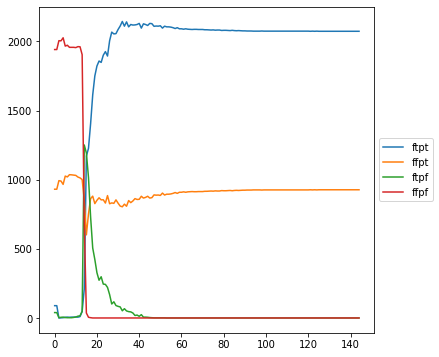

In [20]:
analysis_data = np.array(analysis_data)
plt.figure(figsize=(6,6))
plt.plot(np.arange(0,epoch+3,1),analysis_data[:,0],label="ftpt")
plt.plot(np.arange(0,epoch+3,1),analysis_data[:,1],label="ffpt")
plt.plot(np.arange(0,epoch+3,1),analysis_data[:,2],label="ftpf")
plt.plot(np.arange(0,epoch+3,1),analysis_data[:,3],label="ffpf")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("trends_synthetic_300_300.png",bbox_inches="tight")
plt.savefig("trends_synthetic_300_300.pdf",bbox_inches="tight")


In [21]:
analysis_data[-1,:3]/30

array([69.1, 30.9,  0. ])

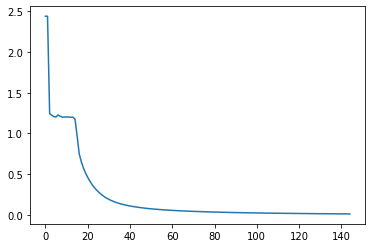

In [22]:
plt.plot(loss_curi)